In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('../data/train_set.csv', encoding='cp437')
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23615 entries, 0 to 23614
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   23615 non-null  int64 
 1   text    23615 non-null  object
dtypes: int64(1), object(1)
memory usage: 369.1+ KB
None
      label                                               text
0  85389000                 pdscpm gb part of panel of chiller
1  85389000  nm  p economical extended rot hand parts for c...
2  85389000  lv ma pd trip unit for cvs parts of circuit br...
3  85389000  lv na p trip unit for cvs switch parts of circ...
4  85389000  lv tmd pd trip unit for cvs parts of circuitbr...


## Encoding the Labels

In [3]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['label'])

## Clean the text

In [4]:
import re
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords as sw
from nltk.stem.porter import PorterStemmer

corpus = []
for i in df['text']:
    sentence = re.sub("[^a-zA-z]", " ", i).lower().split()
    ps = PorterStemmer()
    sentence = [ps.stem(word) for word in sentence if not word in set(sw.words('english'))]
    sentence = ' '.join(sentence)
    corpus.append(sentence)

[nltk_data] Downloading package punkt to /home/sarthak/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Creating Bag of Words

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
x = cv.fit_transform(corpus).toarray()
y = df.iloc[:, 0].values

## Applying Stratified K-fold cross validation

In [6]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
sc = StandardScaler()
X = sc.fit_transform(x)
models = dict()

## Naive Bayes

In [7]:
from sklearn.naive_bayes import GaussianNB
from statistics import mean
nbc = GaussianNB()
accumulate_stratified = []
for train_index, test_index in skf.split(X, y):
    xtrain, xtest = X[train_index], X[test_index]
    ytrain, ytest = y[train_index], y[test_index]
    nbc.fit(xtrain, ytrain)
    accumulate_stratified.append(nbc.score(xtest, ytest))
print(accumulate_stratified)
print(mean(accumulate_stratified))
models[mean(accumulate_stratified)] = nbc

[0.842506350550381, 0.8543607112616427, 0.8543607112616427, 0.8378492802709568, 0.8543607112616427, 0.8377806014400677, 0.829733163913596, 0.8390512494705633, 0.8441338415925456, 0.83142736128759]
0.8425563982310629


## Decision Tree

In [8]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(criterion='entropy', random_state=42)
accumulate_stratified = []
for train_index, test_index in skf.split(X, y):
    xtrain, xtest = X[train_index], X[test_index]
    ytrain, ytest = y[train_index], y[test_index]
    dtc.fit(xtrain, ytrain)
    accumulate_stratified.append(dtc.score(xtest, ytest))
print(accumulate_stratified)
print(mean(accumulate_stratified))
models[mean(accumulate_stratified)] = dtc

[0.9335309060118544, 0.9284504657070279, 0.9259102455546148, 0.9195596951735817, 0.9297205757832345, 0.9216433714527742, 0.9301143583227446, 0.928843710292249, 0.9343498517577298, 0.915713680643795]
0.9267836860699605


## Random Forest

In [9]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=10, criterion="entropy", random_state=42)
accumulate_stratified = []
for train_index, test_index in skf.split(X, y):
    xtrain, xtest = X[train_index], X[test_index]
    ytrain, ytest = y[train_index], y[test_index]
    rfc.fit(xtrain, ytrain)
    accumulate_stratified.append(rfc.score(xtest, ytest))
print(accumulate_stratified)
print(mean(accumulate_stratified))
models[mean(accumulate_stratified)] = rfc

[0.939034716342083, 0.930567315834039, 0.9356477561388654, 0.9250635055038103, 0.9343776460626587, 0.928843710292249, 0.9390088945362135, 0.928843710292249, 0.9449385853451927, 0.9233375688267683]
0.9329663409174129


# Testing the Model on Test Data

## After observing the above predictions, we got to know that for this dataset, Random Forest Algorithm is the best match

In [11]:
print("X :", x[:5])
print("Y :", y[:5])

X : [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Y : [9 9 9 9 9]


In [12]:
df_test = pd.read_csv('../data/test_set.csv', encoding='cp437')
print(df_test.info())
print(df_test.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5894 entries, 0 to 5893
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5894 non-null   object
dtypes: object(1)
memory usage: 46.2+ KB
None
                                                text
0  lv tmd pd trip unit for nh parts of circuit br...
1  module tm analog outputs analog output expansi...
2   command group t iii mechanismt p parts forcir...
3    parts of relayelectrical contact  issu e f xxup
4  parts for programmable logic controllers  dm  ...


In [13]:
corpus = []
for i in df_test['text']:
    sentence = re.sub("[^a-zA-z]", " ", i).lower().split()
    ps = PorterStemmer()
    sentence = [ps.stem(word) for word in sentence if not word in set(sw.words('english'))]
    sentence = ' '.join(sentence)
    corpus.append(sentence)

In [14]:
x_train = X
x_test = cv.transform(corpus).toarray()
x_test = sc.transform(x_test)

## Applying Random Forest Model on Test Data

In [15]:
model = models[max(*list(models.keys()))]
model.fit(x_train, y)
predictions = model.predict(x_test)
print(y[300:310])
print(predictions[300:310])

[9 9 9 9 9 9 9 9 9 9]
[ 9  9 11  9  9  9  9  9  9  9]


## Reverting the data to it's original form

In [16]:
y_original_pridictions = encoder.inverse_transform(predictions)
print(y_original_pridictions[300:310])

[85389000 85389000 87089900 85389000 85389000 85389000 85389000 85389000
 85389000 85389000]


In [17]:
df_test['label'] = y_original_pridictions
print(df_test.info())
print(df_test['label'].unique())
print(df_test['label'].unique().shape)
print(df_test[1000:1010])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5894 entries, 0 to 5893
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5894 non-null   object
 1   label   5894 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 92.2+ KB
None
[85389000 39269099 85369090 85366990 85364900 85177090 73181500 87089900
 84713010 87082900 85238090 33041000]
(12,)
                                                   text     label
1000  non lte non sdh equipment card trage  bkaacasr...  85177090
1001  non lte non sdh equipment card trage  bkaacasr...  85177090
1002  non lte non sdh equipment card trage  bkaacasr...  85177090
1003  non lte non sdh equipment card trage  bkaacasr...  85177090
1004  non lte non sdh equipment card trage  bkaacasr...  85177090
1005  non lte non sdh equipment card trage  bkaacasr...  85177090
1006  snofchtwb pnoucsbbm parts of networking equipm...  85177090
1007  snofchvc pnorw parts of networking equipmen

In [18]:
df_test.to_csv("../data/output_set.csv", index=False)

# Graphs

<AxesSubplot:xlabel='text', ylabel='label'>

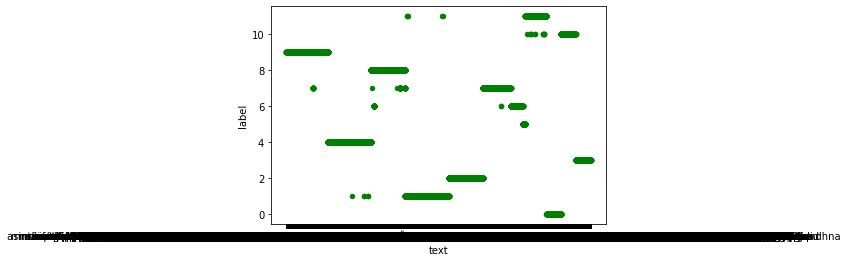

In [19]:
df.plot.scatter(x='text', y='label', c='green')

<AxesSubplot:xlabel='text', ylabel='label'>

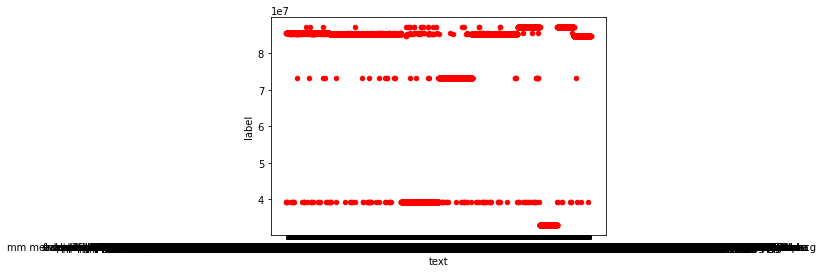

In [20]:
df_test.plot.scatter(x='text', y='label', c='red')